---

## 📚 References

### 🌐 Publications

📖 **Surface Water Mapping**  
_"An Unsupervised, Scalable Surface Water Mapping Using 3D Geometric Properties from Airborne LiDAR Data"_ (under review, 2024)  
*Authors*: Hunsoo Song & Jinha Jung.

### 📁 Sample Data 1 (Dallas, TX)

🔗 Sample data (either DSM or LAS) can be downloaded from the links below:

- **LAS files**: https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/TX_Pecos_Dallas_2018_D19/TX_Pecos_Dallas_B3_2018/LAZ/USGS_LPC_TX_Pecos_Dallas_2018_D19_14SPB9238.laz
https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/TX_Pecos_Dallas_2018_D19/TX_Pecos_Dallas_B3_2018/LAZ/USGS_LPC_TX_Pecos_Dallas_2018_D19_14SPB9239.laz
https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/TX_Pecos_Dallas_2018_D19/TX_Pecos_Dallas_B3_2018/LAZ/USGS_LPC_TX_Pecos_Dallas_2018_D19_14SPB9338.laz
https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/TX_Pecos_Dallas_2018_D19/TX_Pecos_Dallas_B3_2018/LAZ/USGS_LPC_TX_Pecos_Dallas_2018_D19_14SPB9339.laz
- **Source**: https://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Elevation/metadata/TX_Pecos_Dallas_2018_D19/

🌍 View the [sample area on Google Maps](https://www.google.com/maps/@32.8737533,-96.9382253,3684m/data=!3m1!1e3?entry=ttu).

### 📁 Sample Data 2 (West Lafayette, IN)

🔗 Sample data (either DSM or LAS) can be downloaded from the links below:

- **DSM file**: DSM_Purdue.tif (https://lidar.digitalforestry.org/outbox/DSM_Purdue.tif)
- **LAS file**: LAS_Purdue.las (https://lidar.digitalforestry.org/outbox/LAS_Purdue.las)

🌍 View the [sample area on Google Maps](https://www.google.com/maps/@40.4239794,-86.917598,2942m/data=!3m1!1e3?entry=ttu).

---


laspy version: 2.2.0
numpy version: 1.23.0
rasterio version: 1.3.6
scipy version: 1.8.1
cv2 version: 4.4.0
------------------------------------
Created high-res DSM by taking last-return
Created inital water segement
Created final water map


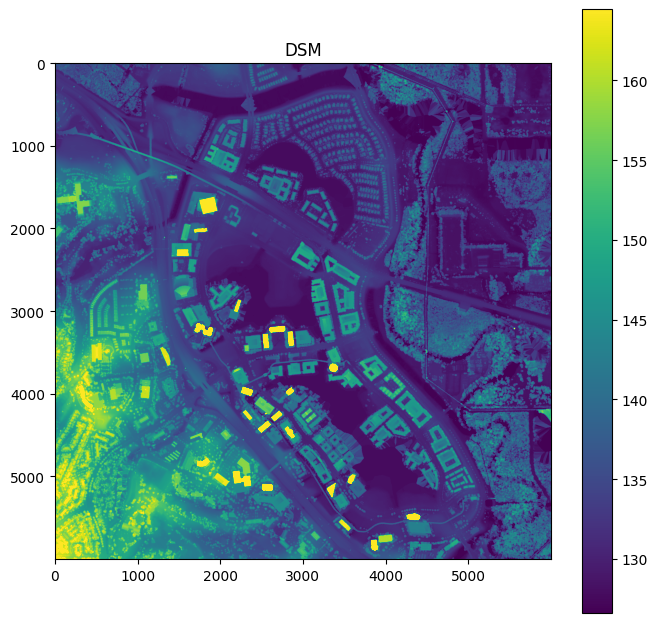

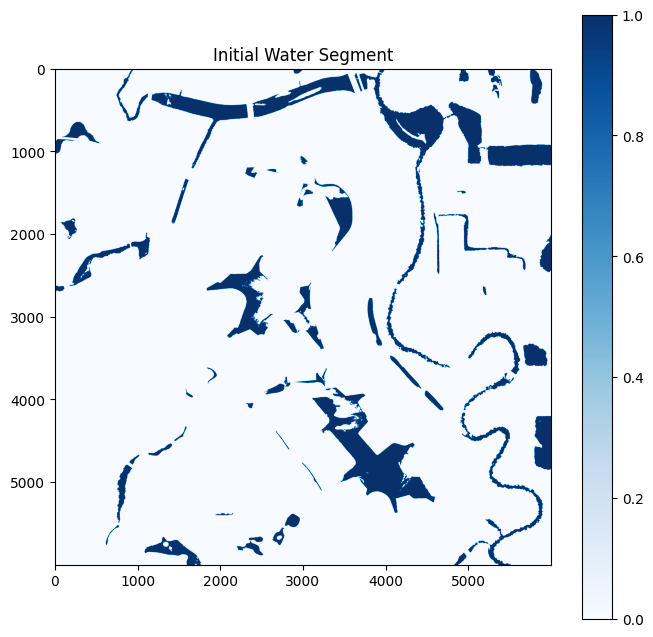

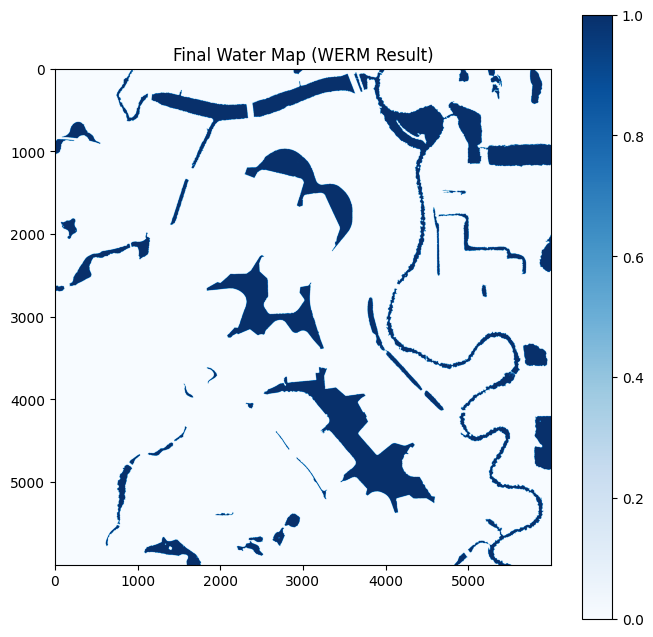

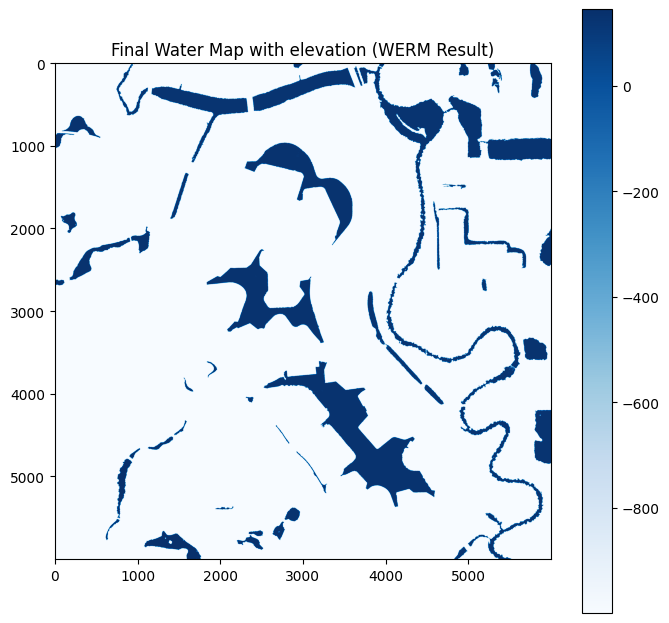

In [1]:
# Import libraries
import laspy
import numpy as np
import rasterio
from rasterio.transform import from_origin
import cv2
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import median_filter, minimum_filter
from scipy.signal import convolve2d as conv2
from scipy import interpolate
from skimage.morphology import remove_small_objects, dilation, square

# Check versions
print("laspy version:", laspy.__version__)
print("numpy version:", np.__version__)
print("rasterio version:", rasterio.__version__)
print("scipy version:", scipy.__version__)
print("cv2 version:", cv2.__version__)
print("------------------------------------")

# Functions
def scipy_interpolation(img, METHOD):
    x = np.arange(0, img.shape[1])
    y = np.arange(0, img.shape[0])
    img = np.ma.masked_invalid(img)
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~img.mask]
    y1 = yy[~img.mask]
    newarr = img[~img.mask]
    interpolated_img = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method=METHOD)
    return interpolated_img

def choose_scale(img_shape): # The higher the scale, the faster the speed.
    """Choose scale based on image shape."""
    if img_shape[0] % 4 == 0 and img_shape[1] % 4 == 0:
        return 4
    elif img_shape[0] % 3 == 0 and img_shape[1] % 3 == 0:
        return 3
    elif img_shape[0] % 2 == 0 and img_shape[1] % 2 == 0:
        return 2
    else:
        return 1
    
def interpolation(img, interpolation_method='linear'):
    SCALE = choose_scale(img.shape)
    dtm_temp = scipy_interpolation(img[::SCALE, ::SCALE], METHOD=interpolation_method)
    dtm_temp = scipy.ndimage.zoom(dtm_temp, SCALE, order=0)
    new_values_for_nan = np.multiply(np.isnan(img), dtm_temp)
    img_with_nan_replaced = np.copy(img)
    img_with_nan_replaced[np.isnan(img)] = 0
    interpolated_img = img_with_nan_replaced + new_values_for_nan
    return interpolated_img

def calculate_density_map(dsm, window_size=9):
    # Create a binary mask where 1 represents valid points and 0 represents missing points
    valid_mask = ~np.isnan(DSM_LAST)
    
    # Use a kernel of ones to compute the sum of valid points in the local window
    kernel = np.ones((window_size, window_size))
    local_sums = conv2(valid_mask, kernel, mode='same')
    
    return local_sums / window_size**2

def classify_water(dsm, target_resolution=0.5, threshold=2, min_area=500):
    densities = calculate_density_map(dsm)
    densities = densities/2
    avg_density = np.mean(densities)
    std_density = np.std(densities)
    potential_water_body = densities < (avg_density - threshold * std_density)

    # Remove small water bodies
    min_pixels = int(min_area / target_resolution**2)
    potential_water_body = remove_small_objects(potential_water_body, min_size=min_pixels)

    return potential_water_body
                    
def calculate_segment_elevation_percentile(dsm, segment, percentile=10):
    # Extract the DSM values where the segment is True
    segment_values = dsm[segment]

    # Calculate the percentile elevation for the segment
    return np.percentile(segment_values[~np.isnan(segment_values)], percentile)

def label_segments(binary_image):
    # Use OpenCV's connected components function
    num_labels, labeled_image = cv2.connectedComponents(np.uint8(binary_image), connectivity=4)

    return labeled_image, num_labels
    
def slice_dsm_by_elevation(dsm, elevation, interval=0.1):
    # Extract regions within a specific elevation interval (DSM's unit is assumed to be meter) 
    lower_bound = elevation - interval
    upper_bound = elevation + interval
    return (dsm >= lower_bound) & (dsm <= upper_bound)

def water_elevation_based_region_merging(dsm, initial_water_segment, percentile=10):
    # Label the initial water segments
    labeled_segments, num_segments = label_segments(initial_water_segment)

    # Initialize the merged segment result and water elevation map
    merged_segment = np.zeros_like(dsm, dtype=bool)
    # Initialize the water elevation map with a unique value (e.g., -999)
    water_elevation_map = np.full_like(dsm, -999, dtype=np.float32)

    # Loop over each unique segment
    for segment_id in range(1, num_segments):  # Start from 1 as 0 is the background
        # Create a mask for the current segment
        segment_mask = labeled_segments == segment_id

        # Calculate elevation percentile for the current segment
        elevation_percentile = calculate_segment_elevation_percentile(dsm, segment_mask, percentile)

        # Slice DSM based on the segment's elevation percentile
        sliced_dsm = slice_dsm_by_elevation(dsm, elevation_percentile)

        # Find intersection
        intersection = segment_mask & sliced_dsm

        if np.any(intersection):
            # Label connected components in the sliced DSM using OpenCV
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(sliced_dsm), connectivity=4)
            
            # Identify the labels in sliced_dsm that intersect with segment_mask
            intersected_labels = np.unique(labels[segment_mask])
            intersected_labels = intersected_labels[intersected_labels != 0]
            
            # Combine segment_mask with only the intersected parts of sliced_dsm
            combined_segment = segment_mask | np.isin(labels, intersected_labels)
        else:
            # If they don't intersect, use only the segment_mask
            combined_segment = segment_mask

        # Add to the merged result and update water elevation map
        merged_segment |= combined_segment
        water_elevation_map[combined_segment] = elevation_percentile

    return merged_segment, water_elevation_map

def DSM_from_LAS(file_paths, unit, EPSG_CODE, target_resolution=0.5):
    # Determine the resolution based on the unit
    resolution = target_resolution / 0.3048 if unit == 'feet' else target_resolution
    
    # Initialize variables to find the global min and max coordinates
    global_x_min, global_y_min = np.inf, np.inf
    global_x_max, global_y_max = -np.inf, -np.inf
    lidar_points_list = []

    # Process each file
    for file_path in file_paths:
        las = laspy.read(file_path)
        
        # Convert coordinates based on unit
        if unit == 'feet':
            points = np.vstack((las.x, las.y, las.z * 0.3048)).transpose()
        else:
            points = np.vstack((las.x, las.y, las.z)).transpose()

        # Update global bounds
        x_min, y_min, x_max, y_max = las.header.mins[0], las.header.mins[1], las.header.maxs[0], las.header.maxs[1]
        global_x_min = min(global_x_min, x_min)
        global_y_min = min(global_y_min, y_min)
        global_x_max = max(global_x_max, x_max)
        global_y_max = max(global_y_max, y_max)

        lidar_points_list.append(points)

    # Merge all points from different files
    all_lidar_points = np.vstack(lidar_points_list)
    ncol_out = round((global_x_max - global_x_min) / resolution)
    nrow_out = round((global_y_max - global_y_min) / resolution)

    # Initialize DSM for last returns with a no-data value
    DSM_LAST = np.full((nrow_out, ncol_out), fill_value=-999, dtype=np.float32)

    # Populate DSM
    for point in all_lidar_points:
        col = int((point[0] - global_x_min) / resolution)
        row = int((global_y_max - point[1]) / resolution)
        
        # Only update if new point is higher, or if no point has been recorded yet
        if DSM_LAST[row, col] == -999 or DSM_LAST[row, col] < point[2]:
            DSM_LAST[row, col] = point[2]

    # 3. Interpolation of DSM_LAST using your function
    DSM_LAST = DSM_LAST.astype('float32')  # Convert the array to float
    DSM_LAST[DSM_LAST == -999] = np.nan
    DSM = interpolation(DSM_LAST, interpolation_method='nearest')
    DSM = DSM.astype('float32')
    
    return DSM_LAST, DSM
    
# Main process

# Input
las_path = ['USGS_LPC_TX_Pecos_Dallas_2018_D19_14SPB9338.laz', 'USGS_LPC_TX_Pecos_Dallas_2018_D19_14SPB9238.laz', 'USGS_LPC_TX_Pecos_Dallas_2018_D19_14SPB9339.laz', 'USGS_LPC_TX_Pecos_Dallas_2018_D19_14SPB9239.laz']
target_resolution = 0.5 # Default is 0.5m resolution

# Operation 1. DSM generation
DSM_LAST, DSM = DSM_from_LAS(las_path, unit='meter', EPSG_CODE=26914)
print("Created high-res DSM by taking last-return")

# Operation 2. Initial Water Segment Extraction
initial_water_segment = classify_water(DSM_LAST)
print("Created inital water segement")

# Operation 3. Water Elevation-based Region Mering (WERM)
water_map, water_elevation_map = water_elevation_based_region_merging(DSM, initial_water_segment)
print("Created final water map")


# Visualization
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(DSM, clim=(np.percentile(DSM, 1), np.percentile(DSM, 99)))
plt.colorbar()
plt.title('DSM')

plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(initial_water_segment, cmap='Blues')
plt.colorbar()
plt.title('Initial Water Segment')
plt.show()

plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(water_map, cmap='Blues')
plt.colorbar()
plt.title('Final Water Map (WERM Result)')
plt.show()

plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(water_elevation_map, cmap='Blues')
plt.colorbar()
plt.title('Final Water Map with elevation (WERM Result)')
plt.show()
